In [1]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D
from gym import wrappers
from matplotlib import pyplot as plt

%matplotlib inline

Using TensorFlow backend.


### 環境建置

In [2]:
env = gym.make("Pong-v0")
state = env.reset()

[2017-05-18 07:40:32,785] Making new env: Pong-v0


### HyperParameters

In [3]:
prev_x = None
score = 0
episode = 0

state_size = 80*80
acttion_size = env.action_space.n

### 畫面前處理

In [4]:
def preprocess(I):
    I = I[35:195]
    I = I[::2, ::2, 0]
    I[I == 144] = 0
    I[I == 109] = 0
    I[I != 0] = 1
    return I.astype(np.float).ravel()

In [5]:
state, _, _, _ = env.step(2)

原始畫面，shape為： (210, 160, 3)


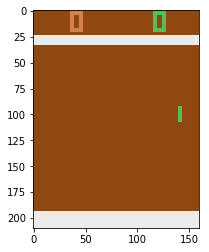

In [6]:
print('原始畫面，shape為：', state.shape)
plt.imshow(state)
plt.show()

剪裁不必要的上下畫面，剪裁後shape為： (160, 160, 3)


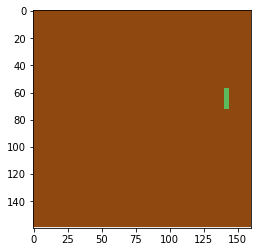

In [7]:
state = state[35:195]
print('剪裁不必要的上下畫面，剪裁後shape為：', state.shape)
plt.imshow(state)
plt.show()

downsample by factor 2： (80, 80)


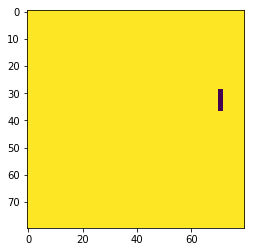

In [8]:
state = state[::2,::2,0]
print('downsample by factor 2：', state.shape)
plt.imshow(state)
plt.show()

In [9]:
print(np.unique(state, return_counts=True))
print()
print('可觀察到144佔了多數，應該是背景，為不必要資訊。')

(array([ 92, 144], dtype=uint8), array([  16, 6384]))

可觀察到144佔了多數，應該是背景，為不必要資訊。


除去背景。


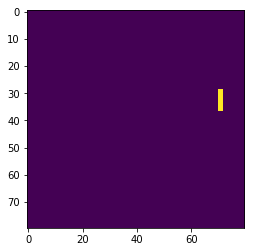

In [10]:
state[state == 144] = 0
print('除去背景。')
plt.imshow(state)
plt.show()

將剩餘的東西（拍子、球）設為1。


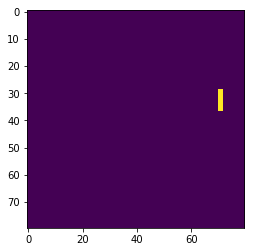

In [11]:
# everything else (paddles, ball) just set to 1
print('將剩餘的東西（拍子、球）設為1。')
state[state != 0] = 1
plt.imshow(state)
plt.show()

In [12]:
print('處理後的資訊如下：')
print(np.unique(state, return_counts=True))
print(state.shape)

處理後的資訊如下：
(array([0, 1], dtype=uint8), array([6384,   16]))
(80, 80)


### 畫面前處理（type II）
* 因為起始畫面是綠色背景，所以只需在擦去背景那一步做一些小小改變即可。

In [13]:
state = env.reset()

如果不做任何action，起始背景會是一片綠，我也不曉得原因。


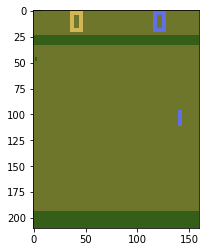

In [14]:
print('如果不做任何action，起始背景會是一片綠，我也不曉得原因。')
plt.imshow(state)
plt.show()

In [15]:
print('一樣做剪裁以及downsample。')
state = state[35:195]
state = state[::2,::2,0]
print('觀察現在state的分佈：\n')
print(np.unique(state, return_counts=True), '\n')
print('可以看到背景都是109。')

一樣做剪裁以及downsample。
觀察現在state的分佈：

(array([ 53, 101, 109], dtype=uint8), array([   2,   16, 6382])) 

可以看到背景都是109。


擦去背景（type II）


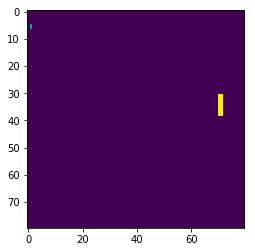

In [16]:
print('擦去背景（type II）')
state[state == 109] = 0
plt.imshow(state)
plt.show()

### 建立產生建議動作機率的神經網路

In [17]:
def _build_model():
    model = Sequential()
    model.add(Reshape((80, 80, 1), input_shape=(80*80,)))
    model.add(Conv2D(32, kernel_size=(6, 6), strides=(3, 3), border_mode='same',
              activation='relu', init='glorot_normal'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', init='glorot_normal'))
    model.add(Dense(32, activation='relu', init='glorot_normal'))
    model.add(Dense(acttion_size, activation='softmax'))
    opt = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    return model

In [18]:
model = _build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 80, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        1184      
_________________________________________________________________
flatten_1 (Flatten)          (None, 23328)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1493056   
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 1,496,518.0
Trainable params: 1,496,518.0
Non-trainable params: 0.0
____________________________________________________________

/home/nailo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, kernel_size=(6, 6), strides=(3, 3), activation="relu", padding="same", kernel_initializer="glorot_normal")`
/home/nailo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="glorot_normal")`
/home/nailo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="glorot_normal")`


### 紀錄每一個episode的內容以及gradients

In [19]:
gradients = []
states = []
rewards = []

def remember(state, action, prob, reward):
    y = np.zeros([acttion_size])
    y[action] = 1 # indicator
    gradients.append(np.array(y).astype('float32') - prob)
    states.append(state)
    rewards.append(reward)

### 預測動作以及挑選動作

In [20]:
probs = []

def act(state):
    state = state.reshape([1, 6400])
    aprob = model.predict(state, batch_size=1).flatten()
    probs.append(aprob)
    prob = aprob / np.sum(aprob)
    action = np.random.choice(acttion_size, 1, p=prob)[0]
    return action, prob

### discount rewards

In [21]:
gamma = 0.99

def discount_rewards(rewards):
    discounted_rewards = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(0, rewards.size)):
        if rewards[t] != 0:
            running_add = 0
        running_add = running_add * gamma + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards

### 訓練

In [22]:
learning_rate = 0.001

def train():
    gradients = np.vstack(gradients)
    rewards = np.vstack(rewards)
    rewards = self.discount_rewards(rewards)
    rewards -= np.mean(rewards)
    rewards /= np.std(rewards)
    gradients *= rewards
    X = np.squeeze(np.vstack([states]))
    Y = probs + learning_rate * np.squeeze(np.vstack([gradients]))
    model.train_on_batch(X, Y)
    # reset env
    states, probs, gradients, rewards = [], [], [], []

### save & load model

In [23]:
def load(name):
    model.load_weights(name)

def save(name):
    model.save_weights(name)

# 整理上述function成一個class

In [24]:
class PGAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99
        self.learning_rate = 0.001
        self.states = []
        self.gradients = []
        self.rewards = []
        self.probs = []
        self.model = self._build_model()
        self.model.summary()

    def _build_model(self):
        model = Sequential()
        model.add(Reshape((80, 80, 1), input_shape=(80*80,)))
        model.add(Conv2D(32, kernel_size=(6, 6), strides=(3, 3), border_mode='same',
                  activation='relu', init='glorot_normal'))
        model.add(Flatten())
        model.add(Dense(64, activation='relu', init='glorot_normal'))
        model.add(Dense(32, activation='relu', init='glorot_normal'))
        model.add(Dense(self.action_size, activation='softmax'))
        opt = Adam(lr=self.learning_rate)
        model.compile(loss='categorical_crossentropy', optimizer=opt)
        return model

    def remember(self, state, action, prob, reward):
        y = np.zeros([self.action_size])
        y[action] = 1
        self.gradients.append(np.array(y).astype('float32') - prob)
        self.states.append(state)
        self.rewards.append(reward)

    def act(self, state):
        state = state.reshape([1, state.shape[0]])
        aprob = self.model.predict(state, batch_size=1).flatten()
        self.probs.append(aprob)
        prob = aprob / np.sum(aprob)
        action = np.random.choice(self.action_size, 1, p=prob)[0]
        return action, prob

    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, rewards.size)):
            if rewards[t] != 0:
                running_add = 0
            running_add = running_add * self.gamma + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards

    def train(self):
        gradients = np.vstack(self.gradients)
        rewards = np.vstack(self.rewards)
        rewards = self.discount_rewards(rewards)
        rewards -= np.mean(rewards)
        rewards /= np.std(rewards)
        gradients *= rewards
        X = np.squeeze(np.vstack([self.states]))
        Y = self.probs + self.learning_rate * np.squeeze(np.vstack([gradients]))
        self.model.train_on_batch(X, Y)
        self.states, self.probs, self.gradients, self.rewards = [], [], [], []

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

### Training Loop

In [25]:
state = env.reset()

state_size = 80 * 80
action_size = env.action_space.n

agent = PGAgent(state_size, action_size)

while True:

    # state使用上個frame減去現在的frame，擷取有移動的資訊
    cur_x = preprocess(state)
    x = cur_x - prev_x if prev_x is not None else np.zeros(state_size)
    prev_x = cur_x

    # 透由神經網路產生動作與動作的機率
    action, prob = agent.act(x)
    state, reward, done, info = env.step(action)
    score += reward
    agent.remember(x, action, prob, reward)

    if done:
        episode += 1
        agent.train()
        print('Episode: %d - Score: %f.' % (episode, score))
        score = 0
        state = env.reset()
        prev_x = None

/home/nailo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, kernel_size=(6, 6), strides=(3, 3), activation="relu", padding="same", kernel_initializer="glorot_normal")`
/home/nailo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="glorot_normal")`
/home/nailo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="glorot_normal")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 80, 80, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 32)        1184      
_________________________________________________________________
flatten_2 (Flatten)          (None, 23328)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1493056   
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 198       
Total params: 1,496,518.0
Trainable params: 1,496,518.0
Non-trainable params: 0.0
____________________________________________________________

KeyboardInterrupt: 

In [ ]:
agent = PGAgent(state_size, action_size)

while True:

    # state使用上個frame減去現在的frame，擷取有移動的資訊
    cur_x = preprocess(state)
    x = cur_x - prev_x if prev_x is not None else np.zeros(state_size)
    prev_x = cur_x

    # 透由神經網路產生動作與動作的機率
    action, prob = agent.act(x)
    state, reward, done, info = env.step(action)
    score += reward
    agent.remember(x, action, prob, reward)

    if done:
        episode += 1
        agent.train()
        print('Episode: %d - Score: %f.' % (episode, score))
        score = 0
        state = env.reset()
        prev_x = None